#### Group 2 - Diabetes readmission prediction

### Summary:
1. Loading

2. Data cleaning
    
    2.1 Standardizing data

    2.2 Inspecting data

    2.3 Dealing with missing values
    
    2.4 Dealing with outliers
    
    2.5 Encoding columns
    
    2.6 Dropping columns

3. Exploratory data analysis

    3.1 General

    3.2 Post modelling

4. Prepare for modelling

    4.1 Checks of prepared data

    4.2 Scaling
    
    4.3 Splitting dataset

    4.4 Balancing

5. Modelling

    5.1 Running models considering the diag columns

    5.2 Running models without the diag columns

    5.3 Running models considering feature selection based on correlation matrices and diag columns

    5.4 Running models considering feature selection based on correlation matrices without diag columns


6. Final considerations

7. Sources


## 1. Loading

Import libraries

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from collections import Counter

from xgboost import XGBClassifier

Load data

In [7]:
data = pd.read_csv("diabetic_readmission_data.csv")

## 2. Data cleaning

### 2.1 Standardizing data

Correct data types

In [8]:
data[["admission_type_id", "admission_source_id", "discharge_disposition_id"]] = data[["admission_type_id", "admission_source_id", "discharge_disposition_id"]].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   encounter_id              101766 non-null  int64   
 1   patient_nbr               101766 non-null  int64   
 2   race                      101766 non-null  object  
 3   gender                    101766 non-null  object  
 4   age                       101766 non-null  object  
 5   weight                    101766 non-null  object  
 6   admission_type_id         101766 non-null  category
 7   discharge_disposition_id  101766 non-null  category
 8   admission_source_id       101766 non-null  category
 9   time_in_hospital          101766 non-null  int64   
 10  payer_code                101766 non-null  object  
 11  medical_specialty         101766 non-null  object  
 12  num_lab_procedures        101766 non-null  int64   
 13  num_procedures            101

Transforming "?" into NaN values

In [9]:
data.replace('?', np.nan, inplace=True)

### 2.2 Inspecting data

In [10]:
# Change settings for maximum number of columns to be displayed 
pd.set_option('display.max_columns', None)


# Take a glance at the first rows
data.head(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),NaN,2,1,2,3,NaN,NaN,31,6,16,0,0,0,414,411,250,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),NaN,3,1,2,4,NaN,NaN,70,1,21,0,0,0,414,411,V45,7,NaN,NaN,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),NaN,1,1,7,5,NaN,NaN,73,0,12,0,0,0,428,492,250,8,NaN,NaN,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),NaN,2,1,4,13,NaN,NaN,68,2,28,0,0,0,398,427,38,8,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),NaN,3,3,4,12,NaN,InternalMedicine,33,3,18,0,0,0,434,198,486,8,NaN,NaN,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [11]:
#Number of rows and columns
data.shape

(101766, 50)

In [12]:
#Info on columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   encounter_id              101766 non-null  int64   
 1   patient_nbr               101766 non-null  int64   
 2   race                      99493 non-null   object  
 3   gender                    101766 non-null  object  
 4   age                       101766 non-null  object  
 5   weight                    3197 non-null    object  
 6   admission_type_id         101766 non-null  category
 7   discharge_disposition_id  101766 non-null  category
 8   admission_source_id       101766 non-null  category
 9   time_in_hospital          101766 non-null  int64   
 10  payer_code                61510 non-null   object  
 11  medical_specialty         51817 non-null   object  
 12  num_lab_procedures        101766 non-null  int64   
 13  num_procedures            101

Since "weight" category is not defined and we can't see the values due to the NaNs, we will be filtering the not NaN values to check the data type

In [13]:
data['weight'].isna().value_counts()

weight
True     98569
False     3197
Name: count, dtype: int64

In [14]:
weightnotnan = data.loc[~data['weight'].isna(), :]

In [15]:
weightnotnan.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1102,8042082,94466574,Caucasian,Male,[50-60),[75-100),6,1,17,2,NaN,Cardiology,68,3,15,0,0,0,786,250,401,6,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
1108,8057670,96198543,NaN,Female,[80-90),[50-75),6,5,17,9,NaN,NaN,74,5,27,0,0,0,414,424,599,7,NaN,NaN,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,>30
1132,8235036,79874631,Caucasian,Female,[60-70),[0-25),6,1,17,5,NaN,Cardiology,71,5,23,0,0,0,414,998,285,7,NaN,NaN,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,>30
1136,8274126,90421380,Caucasian,Female,[40-50),[75-100),6,1,17,3,NaN,NaN,56,3,15,0,0,0,218,112,620,5,NaN,NaN,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
1190,8421486,55628172,Caucasian,Female,[70-80),[75-100),6,6,17,11,NaN,InternalMedicine,78,0,18,0,0,1,410,427,296,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


Checking "payer_code", "max_glu_serum" and "A1Cresult" because in the head we only see NaNs

In [16]:
data['payer_code'].unique()

array([nan, 'MC', 'MD', 'HM', 'UN', 'BC', 'SP', 'CP', 'SI', 'DM', 'CM',
       'CH', 'PO', 'WC', 'OT', 'OG', 'MP', 'FR'], dtype=object)

In [17]:
data['max_glu_serum'].unique()

array([nan, '>300', 'Norm', '>200'], dtype=object)

In [18]:
data['A1Cresult'].unique()

array([nan, '>7', '>8', 'Norm'], dtype=object)

Checking if "insulin", "change" and "diabetedMed" are boolean or not

In [19]:
data['insulin'].unique()

array(['No', 'Up', 'Steady', 'Down'], dtype=object)

In [20]:
data['change'].unique()

array(['No', 'Ch'], dtype=object)

In [21]:
data['diabetesMed'].unique()

array(['No', 'Yes'], dtype=object)

(10) Numerical: encounter_id, patient_nbr, time_in_hospital, num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient, number_diagnoses

(28) Categorical: race, gender, age, weight, admission_type_id, discharge_disposition_id, admission_source_id, payer_code, medical_specialty, diag_1, diag_2, diag_3, max_glu_serum, A1CResult, insulin, metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, ezamide, citoglipton, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, metformin-pioglitazone, readmitted

(2) Boolean/binary: change, diabeterMed

Analysing duplicate patient IDs - We realised we have multiple patients being readmitted and duplicate patient IDs

In [22]:
number_datapoints = len(data)
unique_patients = data['patient_nbr'].nunique()
unique_encounters = data['encounter_id'].nunique()
encounters_per_patient = unique_encounters/unique_patients

print(f"Number of data points in the data set: {number_datapoints}")
print(f"Number of unique encounters: {unique_encounters}")
print(f"Number of unique patients: {unique_patients}")
print(f"Average encounters per patient: {encounters_per_patient}")

Number of data points in the data set: 101766
Number of unique encounters: 101766
Number of unique patients: 71518
Average encounters per patient: 1.4229424760200229


Analyze number of patients vs. encounters

In [23]:
#Closer look into one patient with high number of encounters to check that data is not an incorrect copy
value_counts = data['patient_nbr'].value_counts()  
highest_duplicate_value = value_counts.index[0] 
patient_most_encounters = data.loc[data['patient_nbr'] == highest_duplicate_value, :]
num_most_encounters = len(patient_most_encounters)

print(f"The highest number of encounters per patient is {num_most_encounters}")
print("These are the encounters for this patient:")
patient_most_encounters.head(3)

The highest number of encounters per patient is 40
These are the encounters for this patient:


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
38307,119039172,88785891,Caucasian,Female,[20-30),NaN,1,1,7,1,OG,Emergency/Trauma,32,0,10,0,0,0,250.13,244,490,3,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
40252,125094312,88785891,Caucasian,Female,[20-30),NaN,1,1,7,1,BC,Emergency/Trauma,10,0,10,1,0,2,250.11,244,NaN,2,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,<30
40661,126171582,88785891,Caucasian,Female,[20-30),NaN,1,1,7,5,BC,Emergency/Trauma,35,0,15,1,0,3,250.13,536,V58,6,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30


As this data shows since the rows do not contain the same data, the rows for this patient with the highest number of encounters are not mistakenly copies / duplicates of the same encounter. We come to this conclusion since the values differ between encounters. Therefore, the data seems reliable and we keep all encounters, acknowledging that more weight is given to patients with a high number of encounters.

Almost half of the patients in the data set are readmitted. Specifically, ~35% are readmitted after more than 30 days, and ~11% are readmitted after less than 30 days. We have a class rarity on the latest and we will have to later try applying an oversamplying technique.

### 2.3 Dealing with missing values

In [24]:
#Count number of null values in absolute and relative terms (considering NaN can be expressed by question mark)
null_counts_absolute = data.isnull().sum()
null_counts_relative = (data.isnull().sum() / len(data)) * 100
null_counts = pd.DataFrame({'Absolute': null_counts_absolute, 'Relative (in %)': null_counts_relative})

print(null_counts)

                          Absolute  Relative (in %)
encounter_id                     0         0.000000
patient_nbr                      0         0.000000
race                          2273         2.233555
gender                           0         0.000000
age                              0         0.000000
weight                       98569        96.858479
admission_type_id                0         0.000000
discharge_disposition_id         0         0.000000
admission_source_id              0         0.000000
time_in_hospital                 0         0.000000
payer_code                   40256        39.557416
medical_specialty            49949        49.082208
num_lab_procedures               0         0.000000
num_procedures                   0         0.000000
num_medications                  0         0.000000
number_outpatient                0         0.000000
number_emergency                 0         0.000000
number_inpatient                 0         0.000000
diag_1      

9 columns have missing values out of the 50, which is not that bad!

The ones considered for dropping due to missing values are max_glu_serum, A1CResult and weight since they have very high ratio of missingness. Payer_code also has a lot of missing values and doesn't seem to have importance to the target.

Save all cleaned data in a new DataFrame

In [25]:
data_prepared = data.copy()

Race: impute with mode since there's only 2% missing

In [26]:
data_prepared["race"].fillna(data_prepared["race"].mode()[0], inplace=True)

Gender: drop rows with unknown/invalid gender since there are only 3 instances

In [27]:
data_prepared.drop(data_prepared[data_prepared['gender'] == 'Unknown/Invalid'].index, inplace=True)

Weight: drop column, since we have 97% missing values due to lack of requirement for hospitals to measure weight in structured way

In [28]:
data_prepared = data_prepared.drop(columns="weight")

Payer code: drop column since there are 40% missing values and the relevance for readmission is expected to be low

In [29]:
data_prepared = data_prepared.drop(columns="payer_code")

 Medical specialty: create binary columns "is_missing" and drop original feature due to high number of missing values

In [30]:
data_prepared['medical_specialty_missing'] = data_prepared["medical_specialty"].isna().astype(int)
data_prepared = data_prepared.drop(columns="medical_specialty")

Diagnoses 1-3: replace missing values with mode since there are only 0.02-1.3% of missing values

In [31]:
data_prepared['diag_1'].fillna(data_prepared['diag_1'].mode()[0], inplace=True)
data_prepared['diag_2'].fillna(data_prepared['diag_2'].mode()[0], inplace=True)
data_prepared['diag_3'].fillna(data_prepared['diag_3'].mode()[0], inplace=True)

Max_glu_serum and A1Cresult: Create binary columns "is_missing" when test was not taken since it is potentially relevant. We'll drop the original column due to the high number of missing values.

In [32]:
data_prepared['Max_glu_serum_missing'] = data_prepared['max_glu_serum'].isna().astype(int)
data_prepared['A1C_missing'] = data_prepared['A1Cresult'].isna().astype(int)

data_prepared = data_prepared.drop(columns=["max_glu_serum", "A1Cresult"])

Check if we left something out in the cleaning. Expected to not have missing values anymore on the data.

In [33]:
data_prepared.isna().sum()

encounter_id                 0
patient_nbr                  0
race                         0
gender                       0
age                          0
admission_type_id            0
discharge_disposition_id     0
admission_source_id          0
time_in_hospital             0
num_lab_procedures           0
num_procedures               0
num_medications              0
number_outpatient            0
number_emergency             0
number_inpatient             0
diag_1                       0
diag_2                       0
diag_3                       0
number_diagnoses             0
metformin                    0
repaglinide                  0
nateglinide                  0
chlorpropamide               0
glimepiride                  0
acetohexamide                0
glipizide                    0
glyburide                    0
tolbutamide                  0
pioglitazone                 0
rosiglitazone                0
acarbose                     0
miglitol                     0
troglita

### 2.4 Dealing with outliers

Check distribution of numerical columns

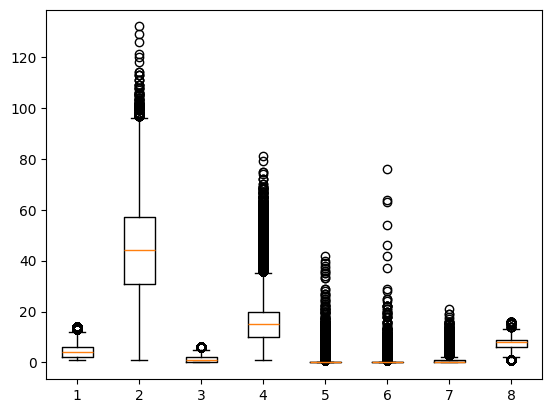

In [34]:
numeric_columns = ["time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications", "number_outpatient", "number_emergency", "number_inpatient", "number_diagnoses"]
plt.boxplot(data_prepared[numeric_columns])
plt.show()

Calculate the number of outliers for each column using the IQR method

In [35]:
outliers = {}
for col in data_prepared[numeric_columns]:
    q1 = data_prepared[col].quantile(0.25)
    q3 = data_prepared[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers[col] = len(data_prepared[(data_prepared[col] < lower_bound) | (data_prepared[col] > upper_bound)])

plt.show()

# Print the number of outliers for each column
print("Number of outliers:")
for col, num_outliers in outliers.items():
    print(f"{col}: {num_outliers}")

Number of outliers:
time_in_hospital: 2252
num_lab_procedures: 143
num_procedures: 4954
num_medications: 2557
number_outpatient: 16739
number_emergency: 11383
number_inpatient: 7049
number_diagnoses: 281


Calculate the number of outliers for each column using the z-score method

In [36]:
z_score_threshold = 3
outliers_z_score = {}
for col in data_prepared[numeric_columns]:
    z_scores = np.abs((data_prepared[col] - data_prepared[col].mean()) / data_prepared[col].std())
    outliers_z_score[col] = sum(z_scores > z_score_threshold)

print("Number of outliers (Z-Score Method):")
for col, num_outliers in outliers_z_score.items():
    print(f"{col}: {num_outliers}")

Number of outliers (Z-Score Method):
time_in_hospital: 1042
num_lab_procedures: 43
num_procedures: 0
num_medications: 1361
number_outpatient: 1457
number_emergency: 1664
number_inpatient: 2016
number_diagnoses: 281


Since the z-score method showed a more consistent number of outliers, lets use this one to decide the columns to impute the mean

In [37]:
# Calculate z-scores of numerical columns and turn these into a DataFrame
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_prepared[numeric_columns])
scaled_df = pd.DataFrame(scaled_features, index=data_prepared.index, columns=numeric_columns)

# Keep values where the absolute z-score is not higher than 1.6, otherwise replace with a missing value
for col in numeric_columns:
    data_prepared[col] = data_prepared[col].where(abs(scaled_df[col]) <= 1.6, None)
    
#Fill missing values with the column's mean (columns did not have missing values before removing the outliers)
for col in numeric_columns:
    median_value = data_prepared[col].median()
    data_prepared[col] = data_prepared[col].fillna(median_value)

Let's check the results of the outlier removal procedure by looking at the number of lab procedures of one of the patients before and after

In [38]:
max_procedures = data["num_lab_procedures"].max()
patient_max_procedures = data.loc[data["num_lab_procedures"] == max_procedures, "patient_nbr"]
check_median = data_prepared.loc[data_prepared["patient_nbr"] == patient_max_procedures.iloc[0], "num_lab_procedures"]
median_lab_procedures = data_prepared["num_lab_procedures"].median()

In [39]:
print(f"The number of lab procedures for patient {patient_max_procedures.iloc[0]} was {max_procedures} and it was an outlier")
print(f"After outlier removal, this value has been replaced with {check_median.iloc[0]}, which is equal to the column's median of {median_lab_procedures}")

The number of lab procedures for patient 95506623 was 132 and it was an outlier
After outlier removal, this value has been replaced with 45.0, which is equal to the column's median of 45.0


### 2.5 Encoding columns

##### 2.5.1 Categorical features

Most patients (59%) are discharged to their home, which is described as the routine discharge (Source 1). Therefore, we are clustering into discharged to home vs. any other discharge type. The result as a binary feature and we can drop the original one. 

In [40]:
data_prepared['discharged_home'] = data_prepared['discharge_disposition_id'].apply(lambda x: 1 if x == 1 else 0)
data_prepared = data_prepared.drop(columns="discharge_disposition_id")

Race and admission_type_id have no logical order, so we'll perform one-hot dummy encoding

In [41]:
encoded_categoricals = pd.get_dummies(data_prepared[["race", "admission_type_id"]]).astype(int)
data_prepared = data_prepared.drop(columns=["admission_type_id", "race"])
data_prepared = pd.concat([data_prepared, encoded_categoricals], axis=1)

Age has a logical order, therefore we'll perform ordinal encoding

In [42]:
mapping_age = {"[0-10)": 1,"[10-20)": 2, "[20-30)": 3, "[30-40)": 4, "[40-50)": 5, "[50-60)": 6, "[60-70)": 7, "[70-80)": 8, "[80-90)": 9, "[90-100)": 10}
data_prepared["age"] = data_prepared["age"].map(mapping_age)

The medication columns also have a logical order, therefore we'll also perform ordinal encoding

In [43]:
medications = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

mapping_medications = {"No": 0, "Down": 1, "Steady": 2, "Up": 3}

for medication in medications:
    data_prepared[medication] = data_prepared[medication].map(mapping_medications)

And so does the target column readmitted, so we'll perform ordinal encoding

In [44]:
data_prepared['readmitted'] = data_prepared['readmitted'].apply(lambda x: 0 if x == 'NO' else (1 if x == '<30' else 2))

Encoding columns with very high number of values: diag_1, diag_2, diag_3

There are some decimal codes. We believe is a mistake because the codes are supposed to have three digits, so we'll transform those floats into integers.

In [45]:
data_prepared["diag_1"] = data_prepared["diag_1"].str.split(".").str[0]
data_prepared["diag_2"] = data_prepared["diag_2"].str.split(".").str[0]
data_prepared["diag_3"] = data_prepared["diag_3"].str.split(".").str[0]

There are also some columns with less than three digits. For those cases, we'll impute with the mode.

In [46]:
mode_value_1 = data_prepared["diag_1"].mode()[0]
mode_value_2 = data_prepared["diag_2"].mode()[0]
mode_value_3 = data_prepared["diag_3"].mode()[0]

data_prepared["diag_1"] = data_prepared["diag_1"].apply(lambda x: mode_value_1 if len(x) < 3 else x)
data_prepared["diag_2"] = data_prepared["diag_2"].apply(lambda x: mode_value_1 if len(x) < 3 else x)
data_prepared["diag_3"] = data_prepared["diag_3"].apply(lambda x: mode_value_1 if len(x) < 3 else x)

In [47]:
data_prepared[["diag_1", "diag_2", "diag_3"]].head(10)

,diag_1,diag_2,diag_3
0,250,276,250
1,276,250,255
2,648,250,V27
3,250,250,403
4,197,157,250
5,414,411,250
6,414,411,V45
7,428,492,250
8,398,427,250
9,434,198,486


In [48]:
# concatenate all three columns of diagnosis on a single list with unique values (since its a set)
diag_codes = set(list(data_prepared["diag_1"]) + list(data_prepared["diag_2"]) + list(data_prepared["diag_3"]))

# converting back to list so every category has an index
index2diag_code = list(diag_codes) 

# get the number of different categories
n_codes = len(diag_codes)

# attributes each category (or code) to its index and putting in a dictionary
diag_code2index = { index2diag_code[i]:i for i in range(n_codes) } 

In [49]:
print("Number of different codes:", n_codes)

print("Index referring to code 753: ", diag_code2index['753'])

Number of different codes: 838
Index referring to code 753:  327


In [50]:
# creating matrixes and a vector for the co_occurence

co_occurrence = np.zeros((n_codes, n_codes))
frequencies = np.zeros((n_codes))

In [51]:
# since we have already dealt with missing values, we will straight add the codes to the vector

for index, row in data_prepared.iterrows():
    diag_codes_for_row = []
    
    # Append individual diagnosis codes for the current row
    diag_codes_for_row.append(row["diag_1"])
    diag_codes_for_row.append(row["diag_2"])
    diag_codes_for_row.append(row["diag_3"])

    for j1 in range(len(diag_codes_for_row)):
        code1 = diag_code2index[diag_codes_for_row[j1]]
        co_occurrence[code1][code1] += 1
        frequencies[code1] += 1

        for j2 in range(j1+1, len(diag_codes_for_row)):
            code2 = diag_code2index[diag_codes_for_row[j2]]
            co_occurrence[code1][code2] += 1
            co_occurrence[code2][code1] += 1

# We want the co_occurrence to be a probability space (sum to one each row)
co_occurrence = co_occurrence / np.sum(co_occurrence, axis=1, keepdims=True)

In [52]:
co_occurrence.shape

(838, 838)

Now we'll apply PCA to the co_occurence matrix

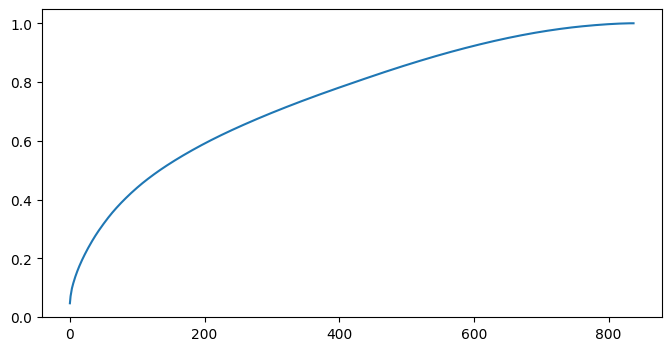

In [53]:
pca = PCA()
pca.fit(co_occurrence)
cumulative_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_explained_variance_ratio)

fig = plt.gcf()
fig.set_size_inches(8, 4)
plt.show()

It looks like 80% of the data is explained by around half of the components, so we will use that. But what is the number exacly?

In [54]:
num_components_for_80_percent = np.argmax(cumulative_explained_variance_ratio >= 0.8) + 1  # +1 because indices are 0-based

num_components_for_80_percent

425

So lets run PCA with that number of components

In [55]:
pca = PCA(n_components=457)
pca.fit(co_occurrence)

# Transform the co_occurrence matrix into a reduced dimensionality form
reduced_co_occurrence = pca.transform(co_occurrence)

In [56]:
reduced_co_occurrence

array([[-0.110383  ,  0.01847364, -0.0263639 , ..., -0.00070254,
        -0.00055542, -0.00394331],
       [ 0.07062265, -0.01557417, -0.02170529, ...,  0.0004071 ,
        -0.03314875,  0.00302369],
       [-0.06712331, -0.01395516, -0.02483872, ...,  0.00172115,
        -0.02742369,  0.00208328],
       ...,
       [-0.04390367, -0.01072494,  0.0286411 , ...,  0.02342634,
        -0.00722665, -0.01789018],
       [ 0.0498976 ,  0.33536998,  0.02962971, ..., -0.00371576,
         0.00264604, -0.01310918],
       [ 0.05949644, -0.02817494, -0.05920639, ...,  0.00178513,
         0.00138441, -0.00200902]])

We will take the average out of the components for each row of the dataset

In [57]:
# Function to get the components for a diagnosis code
def get_components(diagnosis_code):
    
    # Assuming diag_code2index is a dictionary mapping diagnosis codes to indices
    diag_index = diag_code2index.get(diagnosis_code)

    if diag_index is not None:
        return reduced_co_occurrence[diag_index]
    
    else:
        # Handle cases where the diagnosis code is not found in the matrix
        return np.zeros(reduced_co_occurrence.shape[1])  # Return zeros as placeholders

We will apply that function to each diag column and take the average for each row

In [58]:
# List to store the average components for each row
average_components_list = []

# Iterate over each row in the DataFrame
for index, row in data_prepared.iterrows():
    
    # Get the components for each diagnosis code
    diag1_components = get_components(row["diag_1"])
    diag2_components = get_components(row["diag_2"])
    diag3_components = get_components(row["diag_3"])
    
    # Compute the average components for the row
    average_components = (diag1_components + diag2_components + diag3_components) / 3.0
    
        # Compute the average components for the row
    average_components = (diag1_components + diag2_components + diag3_components) / 3.0
    
    # Append the average components to the list
    average_components_list.append(average_components)

Adding the average components to the original dataframe

In [59]:
# Convert the list of average components into a NumPy array
average_components_array = np.array(average_components_list)

# Create new columns for the average components in the original DataFrame
for i in range(average_components_array.shape[1]):
    data_prepared[f"avg_component_{i+1}"] = average_components_array[:, i]

/var/folders/ns/2fdd2j7x5p3dcwpx64zbmjlm0000gn/T/ipykernel_89409/4048641647.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_prepared[f"avg_component_{i+1}"] = average_components_array[:, i]
/var/folders/ns/2fdd2j7x5p3dcwpx64zbmjlm0000gn/T/ipykernel_89409/4048641647.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_prepared[f"avg_component_{i+1}"] = average_components_array[:, i]
/var/folders/ns/2fdd2j7x5p3dcwpx64zbmjlm0000gn/T/ipykernel_89409/4048641647.py:6: PerformanceWarning: DataFrame is highly fragmented.  T

##### 2.5.2 Boolean features

Changing binary columns gender, change and diabetesMed to integers so the model accepts it

In [60]:
data_prepared['gender'] = data_prepared['gender'].replace({'Male': 1, 'Female': 0})
data_prepared['change'] = data_prepared['change'].replace({'Ch': 1, 'No': 0})
data_prepared['diabetesMed'] = data_prepared['diabetesMed'].replace({'Yes': 1, 'No': 0})

### 2.6 Dropping columns

Usually, we would wait for the last step to drop columns. However, we will be running multiple algorithms and they require different things. One of them is sensible to scaling and the other are not, therefore we changed the order to avoid repeating code.

Dropping admission source id due to high overlap with admission type

In [61]:
data_prepared = data_prepared.drop(columns="admission_source_id")

Dropping encounter_id and patient_id since they aren't relevant

In [62]:
data_prepared = data_prepared.drop(columns=["encounter_id", "patient_nbr"])

Dropping diag_1, diag_2 and diag_3 since we've encoded it into the co_occurence matrix and won't be using the original columns

In [63]:
data_prepared = data_prepared.drop(columns=["diag_1", "diag_2", "diag_3"])

## 3. EDA

### 3.1 General

Get summary statistics of the numerical columns after all the cleaning

In [64]:
data_prepared[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']].describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,3.729489,45.143687,0.975335,14.841180,0.154624,0.075440,0.340527,7.944253
std,2.110104,13.613317,1.150503,5.712318,0.448723,0.264101,0.610959,1.445065
min,1.000000,12.000000,0.000000,4.000000,0.000000,0.000000,0.000000,5.000000
25%,2.000000,37.000000,0.000000,11.000000,0.000000,0.000000,0.000000,7.000000
50%,3.000000,45.000000,1.000000,14.000000,0.000000,0.000000,0.000000,9.000000
75%,5.000000,55.000000,2.000000,19.000000,0.000000,0.000000,1.000000,9.000000
max,9.000000,74.000000,4.000000,29.000000,2.000000,1.000000,2.000000,10.000000


In [65]:
lab_proc_mean = data_prepared['num_lab_procedures'].mean()
diag_mean = data_prepared['number_diagnoses'].mean()

print(f"The ratio of lab procedures to diagnosis is {lab_proc_mean/diag_mean}")

The ratio of lab procedures to diagnosis is 5.682559179447597


Interesting. The mean number of diagnoses is 7.4 and the number of lab work is 43. So it takes about ~6 lab procedures to get one diagnosis.

Analyze distribution of target variable 

In [66]:
data_prepared['readmitted'].value_counts(normalize=True)

readmitted
0    0.539106
2    0.349292
1    0.111602
Name: proportion, dtype: float64

Almost half of the patients in the data set are readmitted. Specifically, ~35% are readmitted after more than 30 days, and ~11% are readmitted after less than 30 days. We have a class rarity on the latest and we will have to later try applying an oversamplying technique.

Plotting the histograms of numerical variables

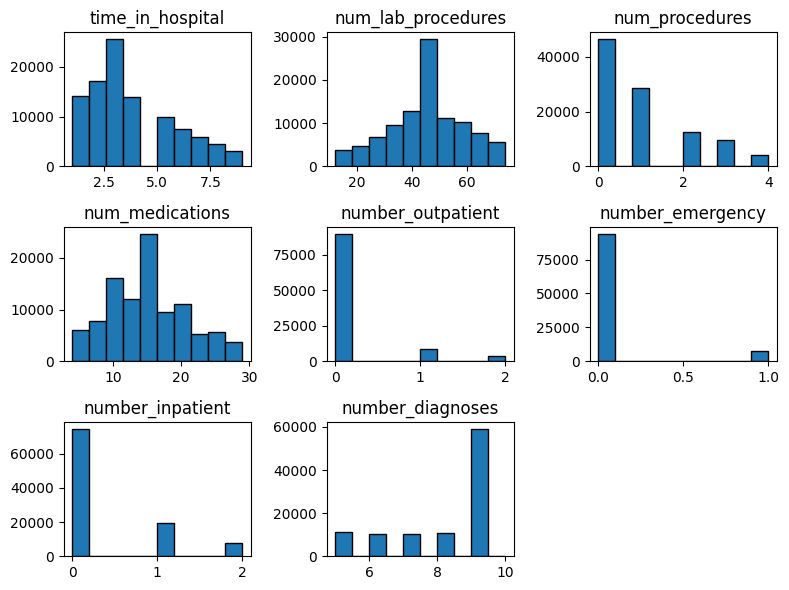

In [67]:
histograms_columns = data_prepared[["time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications", "number_outpatient", "number_emergency", "number_inpatient", "number_diagnoses"]]

histograms_columns.hist(figsize=(8, 6), layout=(3, 3), edgecolor='black', grid=False)

plt.tight_layout()
plt.show()

Comparison of readmission rates across patient-related categories

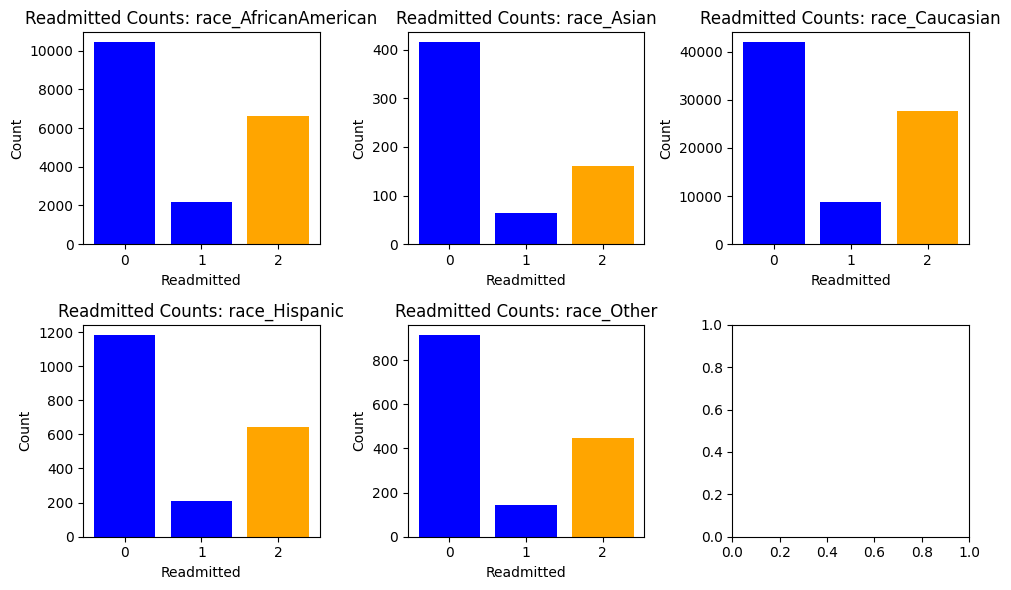

In [68]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6)) 
axes = axes.flatten()

race_columns = ['race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other']

for ax, column in zip(axes, race_columns):
    # For each race, calculate the count of readmitted values
    readmitted_counts = data_prepared[data_prepared[column] == 1]['readmitted'].value_counts()
    ax.bar(readmitted_counts.index, readmitted_counts.values, color=['blue', 'orange'])
    ax.set_title(f'Readmitted Counts: {column}')
    ax.set_xlabel('Readmitted')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

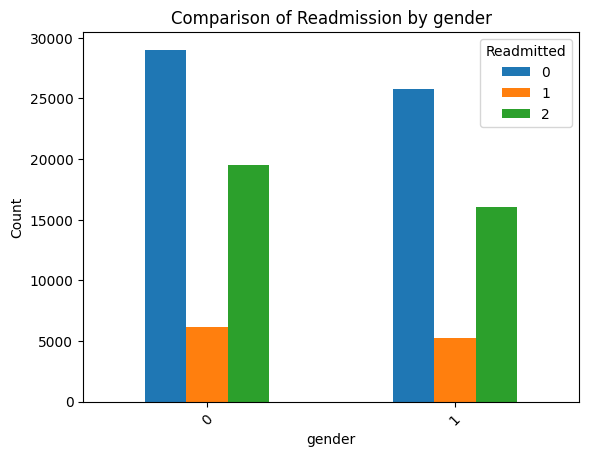

In [69]:
#Comparison of readmission vs no readmission for different categories of gender
summary_table = data_prepared.groupby(['gender', 'readmitted']).size().unstack(fill_value=0)

summary_table.plot(kind='bar', stacked=False)
plt.title('Comparison of Readmission by gender')
plt.xlabel('gender')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Readmitted')

plt.show()

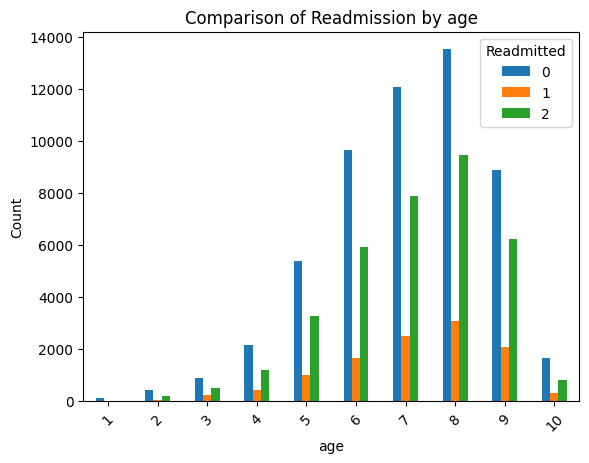

In [70]:
#Comparison of readmission vs no readmission for different categories of age
summary_table = data_prepared.groupby(['age', 'readmitted']).size().unstack(fill_value=0)

summary_table.plot(kind='bar', stacked=False)
plt.title('Comparison of Readmission by age')
plt.xlabel('age')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Readmitted')

plt.show()

Race: The majority of the patients are Caucasian, followed by African American. There is no obvious trend regarding readmission across race.

Gender: The data seems to be more or less balanced across gender, with a slightly higher proportion of females. The readmission rate is similar across both.

Age: The data is clearly skewed towards older patients as expected in this context. The readmission rate behaves similarly, with a slightly higher rate of readmission for older people.

Plotting the resultant most important features from the model versus the readmission

### 3.2 Post modelling

Plotting the most important features versus readmission

Number of procedures

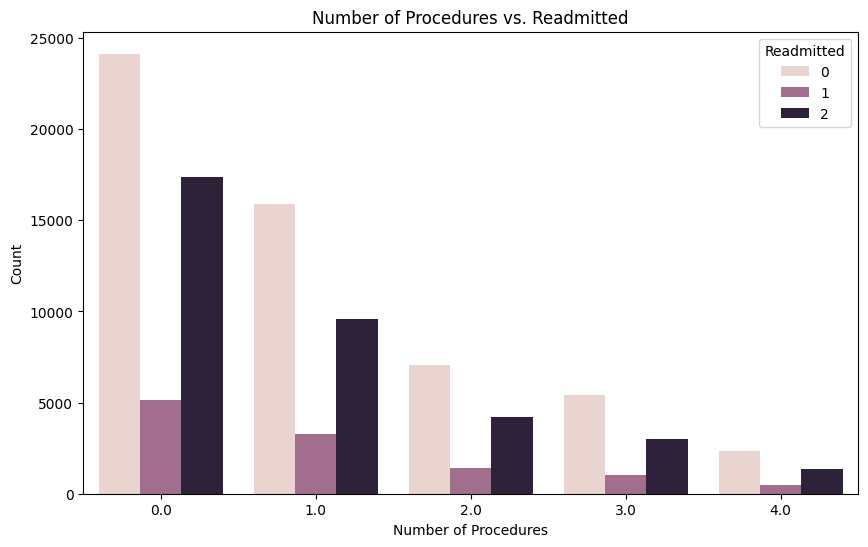

In [76]:
# Plot a count plot of 'num_procedures' against 'readmitted'
plt.figure(figsize=(10, 6))
sns.countplot(x='num_procedures', hue='readmitted', data=data_prepared)
plt.title('Number of Procedures vs. Readmitted')
plt.xlabel('Number of Procedures')
plt.ylabel('Count')
plt.legend(title='Readmitted', loc='upper right')
plt.show()

In [82]:
# get csv for the presentation
# Select 'num_procedures' and 'readmitted' columns
selected_data = data_prepared[['num_procedures', 'readmitted']]

# Save selected data to CSV
selected_data.to_csv('num_procedures_vs_readmitted.csv', index=False)

Age (once more)

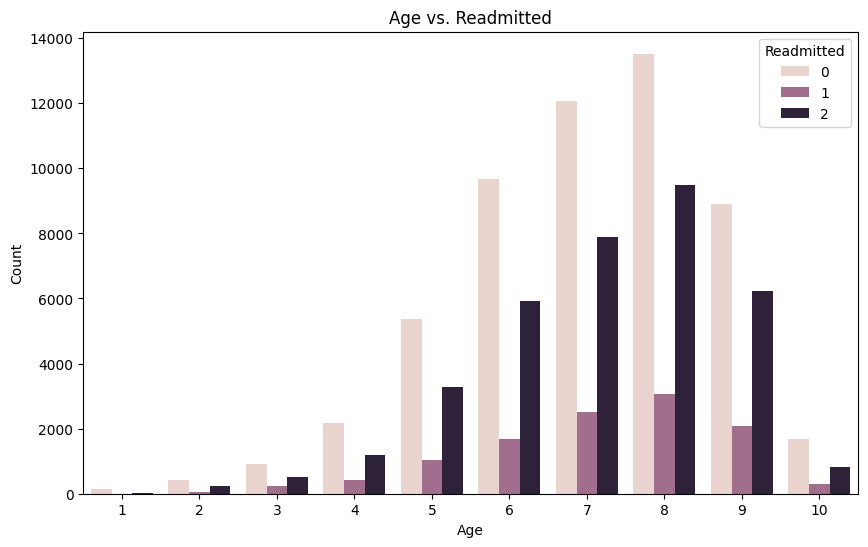

In [77]:
# Plot a count plot of 'num_procedures' against 'readmitted'
plt.figure(figsize=(10, 6))
sns.countplot(x='age', hue='readmitted', data=data_prepared)
plt.title('Age vs. Readmitted')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Readmitted', loc='upper right')
plt.show()

Discharged home

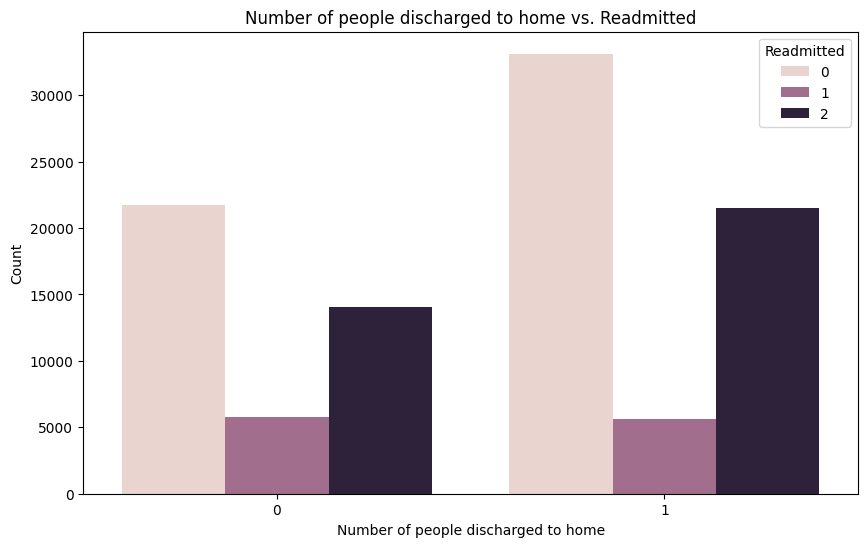

In [78]:
# Plot a count plot of 'num_procedures' against 'readmitted'
plt.figure(figsize=(10, 6))
sns.countplot(x='discharged_home', hue='readmitted', data=data_prepared)
plt.title('Number of people discharged to home vs. Readmitted')
plt.xlabel('Number of people discharged to home')
plt.ylabel('Count')
plt.legend(title='Readmitted', loc='upper right')
plt.show()

Time in hospital

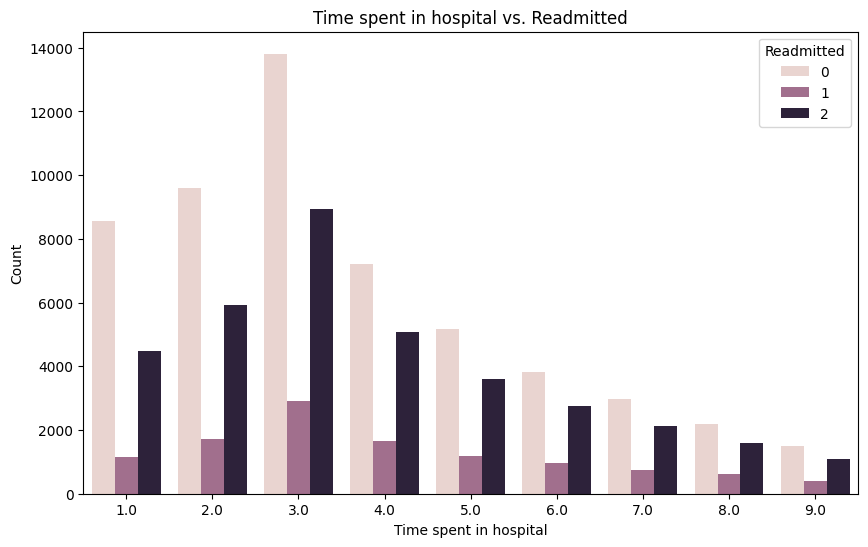

In [79]:
# Plot a count plot of 'num_procedures' against 'readmitted'
plt.figure(figsize=(10, 6))
sns.countplot(x='time_in_hospital', hue='readmitted', data=data_prepared)
plt.title('Time spent in hospital vs. Readmitted')
plt.xlabel('Time spent in hospital')
plt.ylabel('Count')
plt.legend(title='Readmitted', loc='upper right')
plt.show()

Number of emergencies

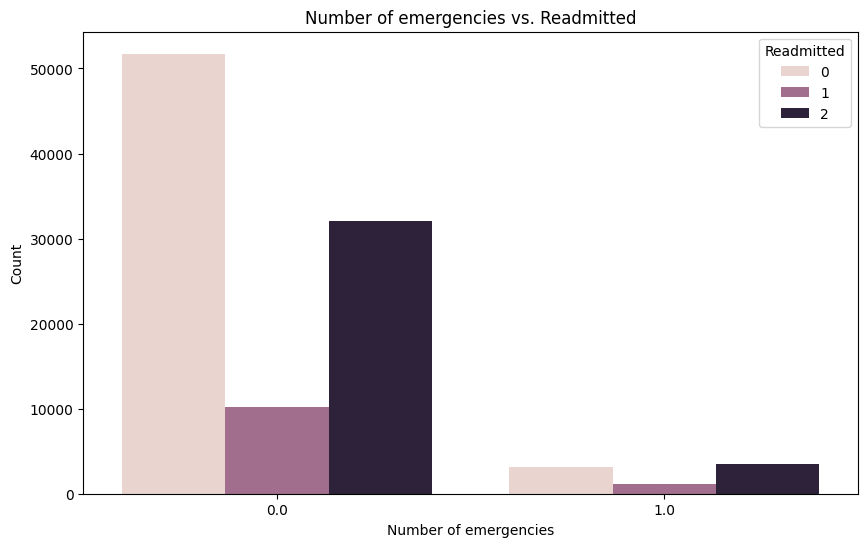

In [80]:
# Plot a count plot of 'num_procedures' against 'readmitted'
plt.figure(figsize=(10, 6))
sns.countplot(x='number_emergency', hue='readmitted', data=data_prepared)
plt.title('Number of emergencies vs. Readmitted')
plt.xlabel('Number of emergencies')
plt.ylabel('Count')
plt.legend(title='Readmitted', loc='upper right')
plt.show()

Number of diagnoses

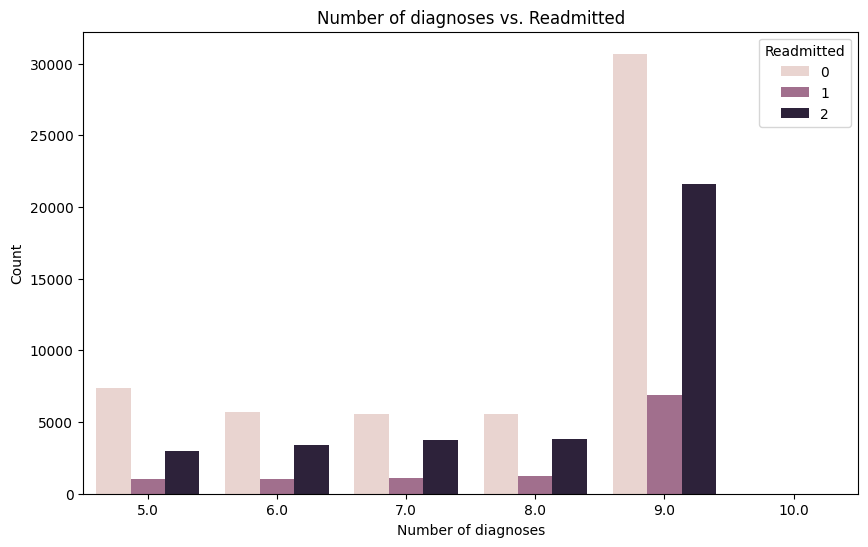

In [81]:
# Plot a count plot of 'num_procedures' against 'readmitted'
plt.figure(figsize=(10, 6))
sns.countplot(x='number_diagnoses', hue='readmitted', data=data_prepared)
plt.title('Number of diagnoses vs. Readmitted')
plt.xlabel('Number of diagnoses')
plt.ylabel('Count')
plt.legend(title='Readmitted', loc='upper right')
plt.show()

In [85]:

# Select 'num_procedures' and 'readmitted' columns
selected_data = data_prepared[['number_diagnoses', 'readmitted']]

# Save selected data to CSV
selected_data.to_csv('number_diagnoses_vs_readmitted.csv', index=False)

## 4. Prepare for modelling

### 4.1 Checks of prepared data

Checking if all data types are integers or floats

In [ ]:
pd.set_option('display.max_rows', None)
data_prepared.dtypes

Yes, all of them are numerical, therefore the data is ready in terms of datatypes

Checking if we have missing values or not

In [ ]:
missing = data_prepared.isna().sum().sum()
missing

We don't have any missing values

### 4.2 Scaling

Lets look at the current scenario of features

In [ ]:
data_prepared.describe()

We will be running Random Forest, Logistic Regression and XGBoost since we'll be dealing with a multiclass output. 

For Logistic Regression, it is important that the variables are scaled. So we'll scale the dataset. 

Apply standard scaling since we've already dealt with outliers

In [ ]:
# Calculate the minimum and maximum values for each column
min_max_values = data_prepared.min()
max_min_values = data_prepared.max()

# Identify columns with values outside the interval [-1, 1]
non_binary_columns = [col for col in data_prepared.columns if min_max_values[col] < -1 or max_min_values[col] > 1]

# Remove the 'readmitted' column if it's in the list
non_binary_columns = [col for col in non_binary_columns if col != 'readmitted']

# Create a DataFrame containing only non-binary columns
data_to_scale = data_prepared[non_binary_columns]

# Initialize MinMaxScaler
scaler = StandardScaler()

# Fit and transform the scaler on the data
scaled_data = scaler.fit_transform(data_to_scale)

# Create a DataFrame from the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=non_binary_columns)

# Replace the non-binary columns in the original DataFrame with the scaled values
data_prepared[non_binary_columns] = scaled_df

The standard scaling is generating NaNs

In [ ]:
data_prepared.isna().sum(axis=1).sum()

Since it's not a lot, we'll drop these rows

In [ ]:
data_prepared = data_prepared.dropna()

### 4.3 Splitting dataset

Reserving a random 15% test set for the end

In [ ]:
X = data_prepared.drop('readmitted', axis=1)
y = data_prepared['readmitted']

X_train, X_test_burn, y_train, y_test_burn = train_test_split(X, y, test_size=0.15, random_state=50)

Splitting again for the train and val (that we commonly use the word "test" as well)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=50)

### 4.4 Balancing the dataset

We previously had used a 0.85 for rebalancing and the results were really bad because the minority class became the majority by 20 p.p.

Let's check the current distribution of the target variable

In [ ]:
# Calculate the count of each unique value in the 'readmitted' column
unique_counts = y_train.value_counts()

# Calculate the percentage of each unique value
percentages = (unique_counts / unique_counts.sum()) * 100

percentages

Applying SMOTE technique to the train set

In [ ]:
# Original distribution of classes
print("Original distribution:", Counter(y_train))

# Applying SMOTE to oversample the minority class
# Adjust 'sampling_strategy' as needed for your balance target
smote = SMOTE(sampling_strategy={1: int(Counter(y)[0] * 0.45)}, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# New distribution of classes
print("New distribution:", Counter(y_train))

Let's check again

In [ ]:
# Calculate the count of each unique value in the 'readmitted' column
unique_counts = y_train.value_counts()

# Calculate the percentage of each unique value
percentages = (unique_counts / unique_counts.sum()) * 100

percentages

# 5. Modelling

We will be running Random Forest, Logistic Regression and XGBoost since we'll be dealing with a multiclass output. We have considered Naive Bayes, but Logistic Regression sounds more suitable when dealing with many instances.

We will also try to drop columns based on correlation matrices in the end.

### 5.1 Running models considering diag columns

#### Random Forest Classifier

In [ ]:
# Initialize the model
model = RandomForestClassifier()

# Train the model
model.fit(X_train, y_train)

# Predictions
train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

# Evaluate the model
print(f"Training accuracy: {accuracy_score(y_train, train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")

# Evaluate the model
print(f"Training report: {classification_report(y_train, train_pred)}")
print(f"Testing report: {classification_report(y_test, y_pred)}")

Since this is a clear overfit, lets try to implement some boundaries

In [ ]:
# Initialize the model
model = RandomForestClassifier(max_depth=35, max_leaf_nodes=70)

# Train the model
model.fit(X_train, y_train)

# Predictions
train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

# Evaluate the model
print(f"Training accuracy: {accuracy_score(y_train, train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")

# Evaluate the model
print(f"Training report: {classification_report(y_train, train_pred)}")
print(f"Testing report: {classification_report(y_test, y_pred)}")

#### Multiclass Logistic Regression

We're running logistic regression with the OVR technique so we can consider multiple classes as an output

In [ ]:
# It reached the max number of iterations and was running for 2 minutes.. so I deleted this parameter

model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Predictions
train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

# Evaluate the model
print(f"Training accuracy: {accuracy_score(y_train, train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")

# Evaluate the model
print(f"Training report: {classification_report(y_train, train_pred)}")
print(f"Testing report: {classification_report(y_test, y_pred)}")

#### XGBoost

In [ ]:
from xgboost import XGBClassifier

# Initialize the XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Fit the model
xgb_model.fit(X_train, y_train)

# Predictions
train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print(f"Training accuracy: {accuracy_score(y_train, train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")

# Evaluate the model
print(f"Training report: {classification_report(y_train, train_pred)}")
print(f"Testing report: {classification_report(y_test, y_pred)}")

### 5.2 Running models without the diag columns
Better predictions than 2.1

#### Random Forest Classifier

Dropping the component columns

In [ ]:
X_train_nodiag = X_train.copy()
X_test_nodiag = X_test.copy()

X_train_nodiag = X_train_nodiag.drop(columns=X_train_nodiag.columns[X_train_nodiag.columns.str.startswith("avg_component")])
X_test_nodiag = X_test_nodiag.drop(columns=X_test_nodiag.columns[X_test_nodiag.columns.str.startswith("avg_component")])

In [ ]:
# Initialize the model
model = RandomForestClassifier()

# Train the model
model.fit(X_train_nodiag, y_train)

# Predictions
train_pred = model.predict(X_train_nodiag)
y_pred = model.predict(X_test_nodiag)

# Evaluate the model
print(f"Training accuracy: {accuracy_score(y_train, train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")

# Evaluate the model
print(f"Training report: {classification_report(y_train, train_pred)}")
print(f"Testing report: {classification_report(y_test, y_pred)}")

The tree is overfitting a lot. Lets use a grid to train it and try to find good parameters.

In [ ]:
# Initialize the model
rfc = RandomForestClassifier()

params = {'max_depth': list(range(5, 21, 1))}

grid = GridSearchCV(rfc, param_grid=params, scoring='accuracy')

grid.fit(X_train_nodiag, y_train)

In [ ]:
grid.best_params_

In [ ]:
results=pd.DataFrame(grid.cv_results_)
results

In [ ]:
# Predictions
train_pred = grid.predict(X_train_nodiag)
y_pred = grid.predict(X_test_nodiag)

# Evaluate the model
print(f"Training accuracy: {accuracy_score(y_train, train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")

# Evaluate the model
print(f"Training report: {classification_report(y_train, train_pred)}")
print(f"Testing report: {classification_report(y_test, y_pred)}")

The overfitting got better.. but not enough. Lets try to limit the leaf nodes. We won't use grid again due to computational efficienty.

In [ ]:
# Initialize the model
model = RandomForestClassifier(max_depth=20, max_leaf_nodes=40)

model.fit(X_train_nodiag, y_train)

# Predictions
train_pred = model.predict(X_train_nodiag)
y_pred = model.predict(X_test_nodiag)

# Evaluate the model
print(f"Training accuracy: {accuracy_score(y_train, train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")

# Evaluate the model
print(f"Training report: {classification_report(y_train, train_pred)}")
print(f"Testing report: {classification_report(y_test, y_pred)}")

Limiting the leaf nodes actually helped with the overfitting! We'll explore that further.

In [ ]:
# Initialize the model
rfc = RandomForestClassifier(max_depth=20)

params = {'max_leaf_nodes': list(range(40, 50, 1))}

grid = GridSearchCV(rfc, param_grid=params)

grid.fit(X_train_nodiag, y_train)

In [ ]:
grid.best_params_

In [ ]:
# Predictions
train_pred = grid.predict(X_train_nodiag)
y_pred = grid.predict(X_test_nodiag)

# Evaluate the model
print(f"Training accuracy: {accuracy_score(y_train, train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")

# Evaluate the model
print(f"Training report: {classification_report(y_train, train_pred)}")
print(f"Testing report: {classification_report(y_test, y_pred)}")

Testing other depths

In [ ]:
# Initialize the model
model = RandomForestClassifier(max_depth=30, max_leaf_nodes=45)

model.fit(X_train_nodiag, y_train)

# Predictions
train_pred = model.predict(X_train_nodiag)
y_pred = model.predict(X_test_nodiag)

# Evaluate the model
print(f"Training accuracy: {accuracy_score(y_train, train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")

# Evaluate the model
print(f"Training report: {classification_report(y_train, train_pred)}")
print(f"Testing report: {classification_report(y_test, y_pred)}")

It didn't help much. Lets try another algorithm.

#### XGBoost

In [ ]:
# Initialize the XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Fit the model
xgb_model.fit(X_train_nodiag, y_train)

# Predictions
train_pred = xgb_model.predict(X_train_nodiag)
y_pred = xgb_model.predict(X_test_nodiag)

# Evaluate the model
print(f"Training accuracy: {accuracy_score(y_train, train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")

# Evaluate the model
print(f"Training report: {classification_report(y_train, train_pred)}")
print(f"Testing report: {classification_report(y_test, y_pred)}")

This is the best result so far.

Let's try with different number of estimators

In [ ]:
# Initialize the model
xgb = XGBClassifier()

params = {'max_depth': [5, 6, 10, 14, 18], 'n_estimators': [2, 5, 17, 19]}

grid = GridSearchCV(xgb, param_grid=params)

grid.fit(X_train_nodiag, y_train)

In [ ]:
grid.best_params_

In [ ]:
# Predictions
train_pred = grid.predict(X_train_nodiag)
y_pred = grid.predict(X_test_nodiag)

# Evaluate the model
print(f"Training accuracy: {accuracy_score(y_train, train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")

# Evaluate the model
print(f"Training report: {classification_report(y_train, train_pred)}")
print(f"Testing report: {classification_report(y_test, y_pred)}")

#### Logistic Regression

In [ ]:
# Initialize the model
model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000)

# Train the model
model.fit(X_train_nodiag, y_train)

# Predictions
train_pred = model.predict(X_train_nodiag)
y_pred = model.predict(X_test_nodiag)

# Evaluate the model
print(f"Training accuracy: {accuracy_score(y_train, train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")

# Evaluate the model
print(f"Training report: {classification_report(y_train, train_pred)}")
print(f"Testing report: {classification_report(y_test, y_pred)}")

### 5.3 Running models considering feature selection based on correlation matrices and diag columns

In [ ]:
X_train_cor = X_train.copy()
X_test_cor = X_test.copy()

# Calculating the matrix
correlation_matrix = X_train_cor .corr()

# Threshold for dropping features
threshold = 0.5

# Find and store pairs of highly correlated features
corr_pairs = correlation_matrix.unstack()
high_corr = corr_pairs[(abs(corr_pairs) > threshold) & (corr_pairs != 1.0)]

# Identify unique features to drop
to_drop = set()
for i, j in high_corr.index:
    if i not in to_drop and j not in to_drop:
        to_drop.add(j)  # Choose one of the features to drop

# Drop the features from the DataFrame
X_train_cor = X_train_cor.drop(columns=to_drop)
X_test_cor = X_test_cor.drop(columns=to_drop)

print(f"Dropped Columns: {to_drop}")
print(f"Remaining Columns: {X_train_cor.columns}")
X_train_cor.shape

Lets try the model with the best result previously trained, which is XGBoost

In [ ]:
# Initialize the XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Fit the model
xgb_model.fit(X_train_cor, y_train)

# Predictions
train_pred = xgb_model.predict(X_train_cor)
y_pred = xgb_model.predict(X_test_cor)

# Evaluate the model
print(f"Training accuracy: {accuracy_score(y_train, train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")

# Evaluate the model
print(f"Training report: {classification_report(y_train, train_pred)}")
print(f"Testing report: {classification_report(y_test, y_pred)}")

It is overfit but changing the parameters didn't seem to help with it.

### 5.4 Running models considering feature selection based on correlation matrices without diag columns

Let's see if we can improve the results by finding highly correlated features and dropping them, since we have many features.

In [ ]:
X_train_cor_nodiag = X_train_nodiag.copy()
X_test_cor_nodiag = X_test_nodiag.copy()

# Calculating the matrix
correlation_matrix = X_train_cor_nodiag.corr()

# Threshold for dropping features
threshold = 0.5

# Find and store pairs of highly correlated features
corr_pairs = correlation_matrix.unstack()
high_corr = corr_pairs[(abs(corr_pairs) > threshold) & (corr_pairs != 1.0)]

# Identify unique features to drop
to_drop = set()
for i, j in high_corr.index:
    if i not in to_drop and j not in to_drop:
        to_drop.add(j)  # Choose one of the features to drop

# Drop the features from the DataFrame
X_train_cor_nodiag = X_train_cor_nodiag.drop(columns=to_drop)
X_test_cor_nodiag = X_test_cor_nodiag.drop(columns=to_drop)

print(f"Dropped Columns: {to_drop}")
print(f"Remaining Columns: {X_train_cor_nodiag.columns}")
X_train_cor_nodiag.shape

In [ ]:
# Initialize the XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Fit the model
xgb_model.fit(X_train_cor_nodiag, y_train)

# Predictions
train_pred = xgb_model.predict(X_train_cor_nodiag)
y_pred = xgb_model.predict(X_test_cor_nodiag)

# Evaluate the model
print(f"Training accuracy: {accuracy_score(y_train, train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")

# Evaluate the model
print(f"Training report: {classification_report(y_train, train_pred)}")
print(f"Testing report: {classification_report(y_test, y_pred)}")

On this case, the diag columns seem important. But what if we try to fit a logistic regression model?

In [ ]:
lr_model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000)

# Fit the model
lr_model.fit(X_train_cor_nodiag, y_train)

# Predictions
train_pred = lr_model.predict(X_train_cor_nodiag)
y_pred = lr_model.predict(X_test_cor_nodiag)

# Evaluate the model
print(f"Training accuracy: {accuracy_score(y_train, train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")

# Evaluate the model
print(f"Training report: {classification_report(y_train, train_pred)}")
print(f"Testing report: {classification_report(y_test, y_pred)}")

It didn't give us a good result.

## 6. Final considerations

Let's recall the best result and predict on the burn test set

In [ ]:
# Initialize the XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Fit the model
xgb_model.fit(X_train_cor, y_train)

# Predictions
train_pred = xgb_model.predict(X_train_cor)
y_pred = xgb_model.predict(X_test_cor)

# Evaluate the model
print(f"Training accuracy: {accuracy_score(y_train, train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")

In [ ]:
X_test_burn.head(5)

In [ ]:
X_test_burn = X_test_burn.drop(columns=['avg_component_15', 'avg_component_18', 'avg_component_16', 'avg_component_59', 'avg_component_25', 'race_Caucasian', 'avg_component_24', 'avg_component_21', 'avg_component_89', 'avg_component_54'])
y_pred_burn = xgb_model.predict(X_test_burn)

print(f"True testing accuracy: {accuracy_score(y_test_burn, y_pred_burn)}")

Now lets look at the parameters that provide interpretation of the results

In [ ]:
# Feature importance
feature_importance = xgb_model.feature_importances_

# Create a list of tuples containing feature names and their importances
feature_importance_list = [(feature_name, importance) for feature_name, importance in zip(X_train.columns, feature_importance)]

# Sort the list of tuples based on feature importances (in descending order)
sorted_feature_importance_list = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

print("Feature Importance (Most to Least):")
for feature_name, importance in sorted_feature_importance_list:
    print(f"{feature_name}: {importance}")

In [ ]:
# Model evaluation
print("Classification Report:")
print(classification_report(y_test_burn, y_pred_burn))

print("Confusion Matrix:")
print(confusion_matrix(y_test_burn, y_pred_burn))

## 7. Sources 

Source 1: https://med.noridianmedicare.com/web/jfa/topics/claim-submission/patient-discharge-status-codes